## Лабораторная работа №1 (курс "Математические методы анализа текстов")

#### Тема: Определение частей речи и выделение именованных сущностей.


**Выдана**:   25 февраля 2017

**Дедлайн**:   <font color='red'>9:00 утра 13 марта 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 2.7)

#### Правила:

Результат выполнения задания - отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев - тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 2.7). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе вам предстоит:

- обучить скрытую марковскую модель на размеченных данных и реализовать алгоритм Витерби для задачи POS-теггинга (определение частей речи слов в тексте)

- научиться использовать ряд POS-теггеров из библиотеки NLTK и сравнить качество их работы

- придумать различные признаки для CRF и использовать их в реализации CRF из пакета CRFsuite для решения задачи NER (выделение именованных сущностей в тексте)

- использовать готовое решение для решения задачи NER и сравнить качество

#### Комментарии и советы:

1. Для выполнения потребуются модули Python numpy, nltk, pycrfsuite (для импорта последнего нужно установить пакет python-crfsuite).

2. Все необходимые для выполнения задания данные либо приложены, либо могут быть скачаны с помощью nltk.download().

3. Посмотреть параметры конструктора и других методов классов можно набрав и выполнив в ячейке с кодом '?full_method_name'.

4. В коде Stanford NER tagger, возможно, присутствует ошибка. Для её устранения в файле /usr/local/lib/python2.7/site-packages/nltk/tag/api.py (или его аналоге в Windows) замените строку с номером 66 на следующую: tagged_sents = self.tag_sents([untag(sent) for sent in gold])

### 1. Определение частей речи (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM). Формула совместной плотности наблюдаемых и скрытых переменных задается как

$$ p(X, T) = p(T) p(X|T) = p(t_1)  \prod_{i=2}^N p(t_i|t_{i-1}) \prod_{i=1}^N p(x_i|t_i)$$

В данном случае:

- наблюдаемые переменные $X$ - это слова корпуса;

- скрытые переменные $T$ - это POS-теги.

#### 1.1. Обучение HMM на размеченных данных

Требуется построить скрытую марковскую модель и настроить все ее параметры с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(t_i | t_{i - 1})$ посчитайте на основе частот биграмм POS-тегов.

- Вероятности эмиссий наблюдаемых состояний $p(x_i | t_i)$ посчитайте на основе частот "POS-тег - слово".

- Обратите внимание на проблему разреженности счетчиков и сделаейте все вероятности сглаженными по Лапласу (add-one smoothing).

- Распределение вероятностей начальных состояний $p(t_1)$ задайте равномерным.

Обратите внимание, что так как мы используем размеченные данные, то у нас нет необходимости в оценивании апостериорных вероятностей на скрытые переменные с помощью алгоритма forward-backword и использовании EM-алгоритма.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class HMM:
    POSTFIX_LEN = 2
    
    MAX_TAGS = 50
    MAX_WORDS = 100000
    MAX_POSTFIX = 40 ** POSTFIX_LEN
    
    def __init__(self, lower=True):
        self.lower = lower
    
    def fit(self, sentences):
        word_tag = np.ones((self.MAX_WORDS, self.MAX_TAGS))
        tag_tag = np.ones((self.MAX_TAGS, self.MAX_TAGS))
        postfix_tag = np.ones((self.MAX_POSTFIX, self.MAX_TAGS))
        
        words_dict = dict()
        tags_dict = dict()
        postfixs_dict = dict()
        
        tag_i, word_i, pfix_i = 0, 0, 0
        for sentence in sentences:
            prev_tag = None
            for word, tag in sentence:
                word, postfix = self.get_word_postfix(word)
                
                if word not in words_dict:
                    words_dict[word] = word_i
                    word_i += 1
                    
                if tag not in tags_dict:
                    tags_dict[tag] = tag_i
                    tag_i += 1

                if postfix not in postfixs_dict:
                    postfixs_dict[postfix] = pfix_i
                    pfix_i += 1
                    
                word_tag[words_dict[word], tags_dict[tag]] += 1
                postfix_tag[postfixs_dict[postfix], tags_dict[tag]] += 1
                if prev_tag is not None:
                    tag_tag[tags_dict[prev_tag], tags_dict[tag]] += 1
                    
                prev_tag = tag
        
        self.word_tag = np.copy(word_tag[:word_i, :tag_i])
        self.tag_tag = np.copy(tag_tag[:tag_i, :tag_i])
        self.postfix_tag = np.copy(postfix_tag[:pfix_i, :tag_i])
        
        self.words_dict = words_dict
        self.tags_dict = tags_dict
        self.postfixs_dict = postfixs_dict
        
        del word_tag
        del tag_tag
        
        self.word_tag_prob = self.word_tag / self.word_tag.sum(axis=0)
        self.postfix_tag_prob = self.postfix_tag / self.postfix_tag.sum(axis=0)
        self.tag_tag_prob = self.tag_tag / self.tag_tag.sum(axis=1)[:, np.newaxis]
        self.tags_dist = np.ones(len(self.tags_dict)) / len(self.tags_dict)
        self.most_freq_tag = self.word_tag.sum(axis=0).argmax()
        
    def predict(self, sentence):
        delta = np.zeros((len(self.tags_dict), len(sentence)))
        s = np.zeros((len(self.tags_dict), len(sentence) - 1), dtype=np.int)
        
        unknowns_indx = []
        
        word, postfix = self.get_word_postfix(sentence[0])
        if word in self.words_dict:
            delta[:, 0] = np.log(self.tags_dist) + np.log(self.word_tag_prob[self.words_dict[word]])
        elif postfix in self.postfixs_dict:
            delta[:, 0] = np.log(self.tags_dist) + np.log(self.postfix_tag_prob[self.postfixs_dict[postfix]])
        else:
            unknowns_indx += [0]
        
        tt_log = np.log(self.tag_tag_prob)
        for i, word in enumerate(sentence[1:]):
            word, postfix = self.get_word_postfix(word)
            
            if word in self.words_dict:
                tmp = delta[:, i, np.newaxis] + tt_log +\
                      np.log(self.word_tag_prob[self.words_dict[word]])
            elif postfix in self.postfixs_dict:
                tmp = delta[:, i, np.newaxis] + tt_log +\
                      np.log(self.postfix_tag_prob[self.postfixs_dict[postfix]])
            else:
                tmp = np.zeros_like(tt_log)
                unknowns_indx += [i + 1]
            
            s[:, i] = np.argmax(tmp, axis=0)
            delta[:, i + 1] = np.max(tmp, axis=0)
            
        tag_by_indx = sorted(self.tags_dict, key=self.tags_dict.get)
        
        tag_indx = np.argmax(delta[:, -1]) if len(sentence) - 1 not in unknowns_indx else self.most_freq_tag
        prediction = [tag_by_indx[tag_indx]]
        for i in range(s.shape[1] - 1, -1, -1):
            tag_indx = s[tag_indx, i]
            if i not in unknowns_indx:
                prediction += [tag_by_indx[tag_indx]]
            else:
                prediction += [tag_by_indx[self.most_freq_tag]]
            
        return prediction[::-1]
    
    def get_word_postfix(self, word):
        if self.lower:
            word = word.lower()
            
        return word, word[-self.POSTFIX_LEN:]

Загрузите brown корпус с универсальной системой тегирования. Для этого вам понадобятся ресурсы brown и universal_tagset из nltk.download().  В этой системе содержатся следующие теги:

- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

Обратите внимание, что тегсеты в корпусах текстов и в различных теггерах могут быть разными. Проверять это можно, глядя на сами теги, а симптом - подозрительно низкое качество теггирования. В таких случаях рекомендуется всё приводить сперва к универсальному тегсету, а потом уже мерять качество. Полезной может оказаться эта ссылка http://www.nltk.org/_modules/nltk/tag/mapping.html

Проанализируйте данные, с которыми Вы работаете. В частности, ответьте на вопросы:
- Каков общий объем датасета, формат?
- Приведены ли слова к нижнему регистру? Чем  это нам может в дальнейшем помешать?
- Как распределены слова в корпусе?  Как распределены теги в корпусе? Подсчитайте частоты и отобразите любым удобным для Вас способом. Проинтерпретируйте полученные результаты.

Задем сделайте случайное разбиение выборки на обучение и контроль в отношении 9:1 и обучите скрытую марковскую модель из предыдущего пункта. Если впоследствии обучение моделей будет занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

In [3]:
from nltk.corpus import brown
from sklearn.model_selection import train_test_split

brown_tagged_sents = brown.tagged_sents(tagset='universal')
X_train, X_test = train_test_split(brown_tagged_sents, train_size=0.9)

In [4]:
len(X_train + X_test), np.mean([len(x) for x in (X_train + X_test)])

(57340, 20.250994070456922)

Общий объем датасета Брауновского корпуса $57340$ предложений по $20$ слов в среднем.

В датасете регистры слов такие, какие они в обычных предложения. Т.е. не приведены к нижнему регистру. Если привести к нижнему регистру, то реализованный алгоритм улучается примерно на $0.5\%$ (с $0.9377$ до $0.9421$). В дальнейшем приведение к нижнему регистру может помешать в определении имен собственных.

In [5]:
hmm = HMM()
%time hmm.fit(X_train)

CPU times: user 2.17 s, sys: 20 ms, total: 2.19 s
Wall time: 2.16 s


In [6]:
words_freq = hmm.word_tag.sum(axis=1)
words_freq = words_freq / words_freq.sum()
words_freq = -np.sort(-words_freq)

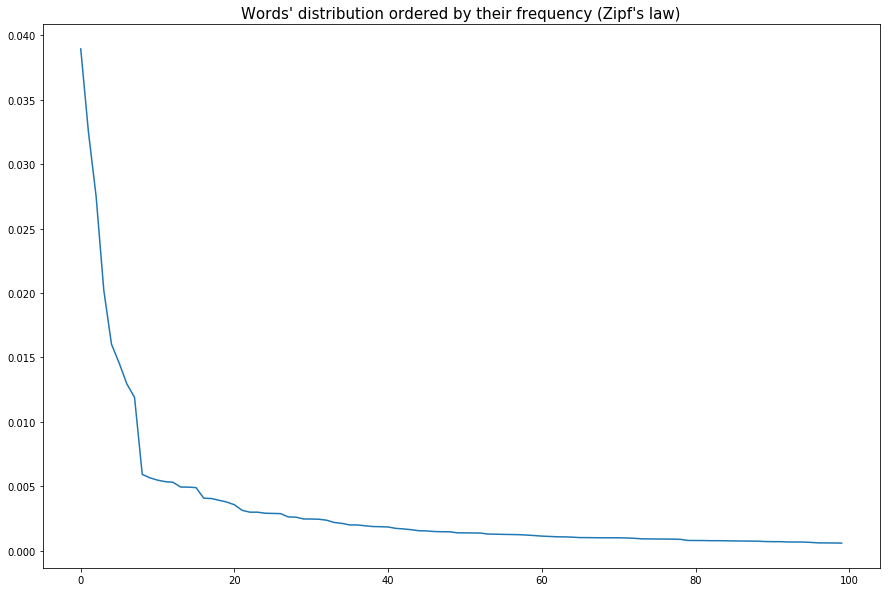

In [7]:
C = 100
plt.figure(figsize=(15, 10))
plt.plot(words_freq[:C])
plt.title(u'Words\' distribution ordered by their frequency (Zipf\'s law)',
          fontdict={'fontsize': 15})
plt.show()

Из графика можно сделать вывод, что закон Ципфа для наших данных тоже выполняется

In [8]:
tags_freq = hmm.word_tag.sum(axis=0)

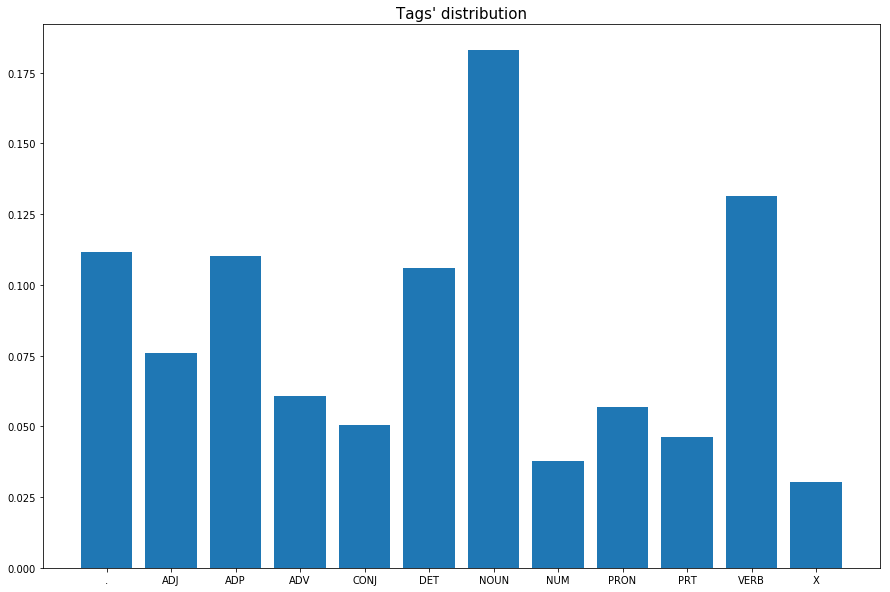

In [9]:
plt.figure(figsize=(15, 10))
tags_names = np.array(sorted(hmm.tags_dict, key=hmm.tags_dict.get))
indx = np.argsort(tags_names)
plt.bar(np.arange(tags_freq.size), tags_freq[indx] / tags_freq.sum())
plt.xticks(np.arange(tags_freq.size), tags_names[indx])
plt.title(u'Tags\' distribution', fontdict={'fontsize': 15})
plt.show()

Теги в корпусе распределены как показано на графике. Больше всего встречается NOUN, что является вполне естественным. Ну и меньше всего неопределенных слов.

#### 1.2 Алгоритм Витерби для применения модели

Чтобы использовать обученную модель для определения частей речи на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{T} = \arg \max_{T} p(T|X) = \arg \max_{T} p(X, T) $$

Определим функцию, определяющую максимальную вероятность последовательности, заканчивающейся на $i$-ой позиции в состоянии $k$:

$$\delta(k, i) = \max_{t_1, \dots t_{i-1}} p(x_1, \dots x_i, t_1, \dots t_i=k)$$

Тогда $\max_{k} \delta(k, N)$ - максимальная вероятность всей последовательности. А состояния, на которых эта вероятность достигается - ответ задачи.

Алгоритм Витерби заключается в последовательном пересчете функции $\delta(k, i)$ по формуле:

$$\delta(k, i) = \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$

Аналогично пересчитывается функция, определяющая, на каком состоянии этот максимум достигается:

$$s(k, i) = \arg \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$


На практике это означает заполнение двумерных массивов размерности: (длина последовательности) $\times$ (количество возможных состояний). Когда массивы заполнены, $\arg \max_{k} \delta(k, N)$ говорит о последнем состоянии. Начиная с него можно восстановить все состояния по массиву $s$. 

Осталось уточнить, как стартовать последовательный пересчет (чем заполнить первый столбец массива вероятностей):

$$\delta(k, 1) = p(k) p(x_1|t_1=k)$$

В реализации рекомендуется перейти к логарифмам, т.к. произведение большого числа маленьких вероятностей может приводить к вычислительным ошибкам.

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'he can stay'
- 'a milk can'
- 'i saw a dog'
- 'an old saw'

In [10]:
hmm.predict('he can stay'.split(' '))

[u'PRON', u'VERB', u'VERB']

In [11]:
hmm.predict('a milk can'.split(' '))

[u'DET', u'NOUN', u'VERB']

In [12]:
hmm.predict('i saw a dog'.split(' '))

[u'PRON', u'VERB', u'DET', u'NOUN']

In [13]:
hmm.predict('an old saw'.split(' '))

[u'DET', u'ADJ', u'VERB']

Ошибки в определении частей речи для слов 'can' и 'saw' происходят из-за частоты словосочетаний с этими словами. Например, рассмотрим слово 'saw'

In [14]:
hmm.word_tag[hmm.words_dict[u'saw']][hmm.tags_dict['NOUN']]

6.0

In [15]:
hmm.word_tag[hmm.words_dict[u'saw']][hmm.tags_dict['VERB']]

318.0

Как видно, слов 'saw' таких, что они NOUN всего 6 штук, а VERB 318. Но ведь марковская модель определяет еще и по пред. слову, скажите вы. Но таких словосочетаний, когда перед saw не местоимение или существительное очень мало либо вообще нет. Например поищем 'a saw'

In [16]:
for sent in X_train:
    if ' a saw ' in ' '.join(map(lambda x: x[0].lower(), sent)):
        print map(lambda x: x[0].lower(), sent)
        print '\n'

Таких словосочетаний в обучающей выборке нету вообще

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
def score(clf, X_test):
    accuracy = []
    for sentence in X_test:
        test_sent = map(lambda x: x[0], sentence)
        test_ans = map(lambda x: x[1], sentence)
        accuracy += [accuracy_score(test_ans, clf.predict(test_sent))]
        
    return np.mean(accuracy)

In [19]:
score(hmm, X_test)

0.94194848431583567

Такая хорошая точность достигается благодаря размеру обучающей выборки. Но даже в большой выборке может случиться так, что не будет слова из теста. В таких случаях определяем по окончанию (хороший результат показывает окончание из 2х символов). Если даже нет слов с таким окончанием, то присваиваем наиболее часто встречающийся тэг.

#### 1.3. Готовые POS-теггеры из NLTK

В прошлом пункте Вы реализовали свой POS-тегер на основе скрытой марковской модели. Теперь сравните его работу с готовыми средставми, доступными в библиотеке NLTK: http://www.nltk.org/api/nltk.tag.html

Примерный набор кандидатов для сравнения:
- Простейший теггер, который всем словам ставит в соответствие одну и ту же метку
- Основанный на правилах RegexpTagger (правила можно поискать в Интернете или придумать самим)
- N-граммные теггеры (разберитесь и поэкспериментируйте с параметром backoff)
- Теггеры на основе графических моделей (можно взять только Stanford): 
    - HiddenMarkovModelTagger
    - CRFTagger
    - StanfordPOSTagger (потребуется .jar файл теггера и обученная модель (легко находятся в Интернете), чтобы подать на вход конструктору класса)
- BrillTagger, основанный на трансформациях

Если работа с какими-то модулями приводит к техническим проблемам, которые Вы не можете решить, это не страшно, модуль можно пропустить. Однако навык быстрого освоения документации / поиска моделей в гугле полезен.  Чем более полным и корректным будет сравнение, тем лучше.

При проведении экспериментов обращайте внимание на следующие моменты (и отразите их в отчете):
- Какой подход лежит в основе теггера
- На каких данных он обучен (если Вы скачали готовую модель)
- Сколько времени занимает обучение на brown корпусе (если обучаете сами)
- Какая точность получается на контролькой выборке (метод evaluate())

Сформируйте рекоммендиции о том, какую технологию Вы бы использовали, если встретитесь с задачей определения частей речи в будущем.

In [20]:
import nltk
from nltk.tag import DefaultTagger
from nltk.tag import RegexpTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag import BrillTaggerTrainer

In [21]:
def score_nltk(clf, X_test, convert=False):
    accuracy = []
    for sentence in X_test:
        test_sent = map(lambda x: x[0], sentence)
        test_ans = map(lambda x: x[1], sentence)
        pred = clf.tag(test_sent)
        for i in range(len(pred)):
            if pred[i][1] is None:
                pred[i] = (pred[i][0], '')
                
        if convert:
            pred = [(p[0], nltk.tag.mapping.map_tag('en-ptb', 'universal', p[1])) for p in pred]
                
        accuracy += [accuracy_score(test_ans, map(lambda x: x[1], pred))]
        
    return np.mean(accuracy)

##### DefaultTagger

In [22]:
%%time
dtg = DefaultTagger('NOUN')
print 'Accuracy for DefaultTagger is', score_nltk(dtg, X_test)

Accuracy for DefaultTagger is 0.230207571623
CPU times: user 627 ms, sys: 0 ns, total: 627 ms
Wall time: 625 ms


DefaultTagger всегда выдает заданное значение тэга. Соотвественно, точность будем такой же, сколько частота этого тэга в обучающих данных. Работает быстро

##### RegexpTagger

In [23]:
%%time
rtg = RegexpTagger([
    # numbers
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),
    (r'.*one$', 'NUM'),
    (r'.*two$', 'NUM'),
    (r'.*three$', 'NUM'),
    (r'.*four$', 'NUM'),
    (r'.*five$', 'NUM'),
    (r'.*six$', 'NUM'), 
    (r'.*seven$', 'NUM'), 
    (r'.*eight$', 'NUM'),
    (r'.*nine$', 'NUM'), 
    (r'.*ten$', 'NUM'), 
    (r'.*eleven$', 'NUM'), 
    (r'.*twelve$', 'NUM'),
    
    # articles
    (r'(The|the|A|a|An|an|some)$', 'DET'),
    
    # adjectives
    (r'.*able$', 'ADJ'), 
    (r'.*less$', 'ADJ'), 
    (r'.*ish$', 'ADJ'),
    (r'.*ful$', 'ADJ'), 
    (r'.*ible$', 'ADJ'),
    
    # adverbs
    (r'.*ly$', 'ADV'),
    
    # verbs
    (r'.*ing$', 'VERB'),
    (r'.*ed$', 'VERB'),
    
    # adposition
    (r'(on|of|at|in)$', 'ADP'),
    
    # pronoun
    (r'(he|she|it|me|you|they|their)$', 'VERB'),
    
    # punctuation
    (r'(\.|\,|\;|\:)', '.'),
    
    # nouns
    (r'.*ness$', 'NOUN'),
    (r'.*s$', 'NOUN'),
    (r'.*', 'NOUN')
])
print 'Accuracy for RegexpTagger is', score_nltk(rtg, X_test)

Accuracy for RegexpTagger is 0.540588069891
CPU times: user 5.11 s, sys: 13.3 ms, total: 5.12 s
Wall time: 5.11 s


RegexpTagger работает хорошо, но в прямой зависимости от регулярных выражений. Обучается дольше, чем HMM и точность в моем случае намного хуже

##### UnigramTagger

In [24]:
%%time
utg = UnigramTagger(train=X_train)
print 'Accuracy for UnigramTagger is', score_nltk(utg, X_test)

Accuracy for UnigramTagger is 0.930535281044
CPU times: user 2.48 s, sys: 23.3 ms, total: 2.5 s
Wall time: 2.48 s


In [25]:
%%time
utg = UnigramTagger(train=X_train, backoff=dtg)
print 'Accuracy for UnigramTagger with backoff is', score_nltk(utg, X_test)

Accuracy for UnigramTagger with backoff is 0.945201888321
CPU times: user 3.3 s, sys: 56.7 ms, total: 3.35 s
Wall time: 3.28 s


UnigramTagger обучается на 1-граммах сопоставляя наиболее вероятный тэг слову. Т.е. нету зависимости от соседних слов. Если использовать backoff метод (например, DefaultTagger), то точность возрастает примерно на 1%. По времени и точности работает в среднем так же, как и HMM

##### BigramTagger

In [26]:
%%time
btg = BigramTagger(train=X_train)
print 'Accuracy for BigramTagger is', score_nltk(btg, X_test)

Accuracy for BigramTagger is 0.552745797469
CPU times: user 3.92 s, sys: 53.3 ms, total: 3.97 s
Wall time: 3.88 s


In [27]:
%%time
btg = BigramTagger(train=X_train, backoff=utg)
print 'Accuracy for BigramTagger is', score_nltk(btg, X_test)

Accuracy for BigramTagger is 0.952967076344
CPU times: user 4.76 s, sys: 36.7 ms, total: 4.8 s
Wall time: 4.74 s


BigramTagger работает аналогично UnigramTagger, только используется 2-граммы. Показывает слабый результат ~55%, но если использовать backoff (UnigramTagger), то точность резко возрастает до 95%.

##### TrigramTagger

In [28]:
%%time
ttg = TrigramTagger(train=X_train)
print 'Accuracy for TrigramTagger is', score_nltk(ttg, X_test)

Accuracy for TrigramTagger is 0.355547906295
CPU times: user 4.65 s, sys: 83.3 ms, total: 4.74 s
Wall time: 4.61 s


In [29]:
%%time
ttg = TrigramTagger(train=X_train, backoff=btg)
print 'Accuracy for TrigramTagger is', score_nltk(ttg, X_test)

Accuracy for TrigramTagger is 0.952776179233
CPU times: user 6.61 s, sys: 53.3 ms, total: 6.66 s
Wall time: 6.6 s


TrigramTagger работает аналогично UnigramTagger, только используется 3-граммы. Показывает очень слабый результат ~35%, но если использовать хороший backoff (BigramTagger), то точность резко возрастает до 95%.

Далее тэггеры работают долго, поэтому выберем подвыборку adventure

In [30]:
X_tr, X_te = train_test_split(brown.tagged_sents(categories='adventure', tagset='universal'), train_size=0.9)

##### StanfordPOSTagger

In [31]:
stanford_dir = 'data/stanford-postagger-full-2016-10-31/'
modelfile = stanford_dir + 'models/english-bidirectional-distsim.tagger'
jarfile = stanford_dir + 'stanford-postagger.jar'

In [32]:
%%time
stg = StanfordPOSTagger(model_filename=modelfile, path_to_jar=jarfile)
print 'Accuracy for StanfordPOSTagger is', score_nltk(stg, X_te[:100], convert=True)

Accuracy for StanfordPOSTagger is 0.915705788127
CPU times: user 267 ms, sys: 3.33 s, total: 3.6 s
Wall time: 1min 38s


StanfordPOSTagger ипользует модель максимальной энтропии. Работает очень долго. Модель уже использует обученные данные (english-bidirectional-distsim.tagger). Точность чуть хуже чем у HMM

##### BrillTagger

In [33]:
%%time
brtg_trainer = BrillTaggerTrainer(btg, nltk.brill.brill24())
brtg = brtg_trainer.train(X_tr)

CPU times: user 14.7 s, sys: 123 ms, total: 14.9 s
Wall time: 14.7 s


In [34]:
print 'Accuracy for BrillTagger is', score_nltk(brtg, X_te)

Accuracy for BrillTagger is 0.979812646188


BrillTagger работает максимизируя качество базового алгоритма в соответствии правилам (templates). На данных brown категории adventure показал очень хороший результат, лучший, чем у HMM. Но по времени проигрывает.

<b>В итоге можно заключить слеующее</b>:

- HMM по критерию время-точность работает лучше всех
- Если нужен очень хороший результат и не важно время работы, то BrillTagger лучший выбор

### 2. Выделение именованных сущностей (NER)



#### 2.1. Генерация признаков для CRF

Выделение именованных сущностей - другая распространенная задача разметки последовательности слов. Чаще всего она решается марковскими моделями максимальной энтропии (MEMM) или условными случайными полями (CRF). При этом основная сложность заключается в генерации  хороших признаков. 

В данном задании Вам требуется придумать и использовать множество признаков для обучения CRF из библиотеки CRFsuite. В этой библиотеке реализована linear-chain CRF с потенциалами двух типов (аналогично HMM):

$$ \psi_{mk}(t_{i-1}, t_{i}) = [t_{i-1} = m] \, [t_{i} = k]; \quad \psi_{jk}(t_{i}, x_i) = [t_{i} = k] \, f_j(x_i)$$


Потенциалы первого типа назвают transition features, они зависят только от биграмм меток. Потенциалы второго типа -- label-observation (node-observation) featrues; они зависят от метки и признаков наблюдаемого слова (observation features). Несмотря на то, что в формуле явно участвует текущее слово $x_i$, подход остается полностью корректным, когда признаки зависят также от контекста слова (соседних слов). Это следствие того, что CRF является дискриминативной моделью, и наблюдаемые переменные $X$ не моделируются. 


**Указания к заданию:** 
- Загрузите из NLTK обучающие и тестовые датасеты для задачи выделения именованных сущеностей CoNLL 2002 shared task на английском, испанском и голландском языках в BIO-нотации (nltk.corpus.conll2002).
- Для обучения CRF модели библиотеке необходимо передать последовательность наблюдаемых признаков $f_j(x_i)$ и меток $y_i$. Ниже приведен весь технический код, который позволит сконцентрироваться только на самом творческом этапе -- генерации признаков.
- Оцените качество приведенного решения. 
- Ваша задача заключается в том, чтобы повысить его. Помимо генерации новых признаков, можно обратить внимание на параметры обучения, в частности, feature.minfreq позволяет отсеивать редкие признаки.  
- При проверке задания будет оцениваться как достигнутое качество, так и разнообразие/оригинальность использованных признаков. Если вы попробовали какие-то признаки, но они не помогли, также включите их в отчет. 
- Если у Вас закончилась фантазия, почитайте обзоры и статьи по теме.


In [1]:
from nltk.corpus import conll2000, conll2002
from sklearn.metrics import accuracy_score

In [2]:
def wse(word, reduced=False):  # Word-shape encoding
    code = ''
    prev = ''
    for c in word:
        if c.islower():
            mark = 'x'
        elif c.isupper():
            mark = 'X'
        elif c.isdigit():
            mark = 'd'
        else:
            mark = c
        
        if reduced:
            if prev != mark:
                code += mark
        else:
            code += mark
        prev = mark

    return code

In [3]:
# Let's define very simple example features.

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=%s' % word.lower(),
        'word[-3:]=%s' % word[-3:],
        'word[-2:]=%s' % word[-2:],
        'word[:3]=%s' % word[:3],
        'word[:2]=%s' % word[:2],
        'word.istitle=%s' % word.istitle(),
        'word.isalphas=%s' % word.isalpha(),
        'word.isalnum=%s' % word.isalnum(),
        'word.isdigit=%s' % word.isdigit(),
        'word.isupper=%s' % word.isupper(),
        'word.islower=%s' % word.islower(),
        'postag=%s' % postag,
        'postag[:2]=%s' % postag[:2],
        'postag[-2:]=%s' % postag[-2:],
        'hashypen=%s' % ('-' in word),
        'wse=%s' % wse(word),
        'wse_red=%s' % wse(word, True),
    ]
    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        features.extend([
            '-1:word[-2:]=%s' % word1[-2:],
            '-1:word.lower=%s' % word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isalphas=%s' % word1.isalpha(),
            '-1:word.isalnum=%s' % word1.isalnum(),
            '-1:word.isdigit=%s' % word1.isdigit(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.islower=%s' % word1.islower(),
            '-1:postag=%s' % postag1,
#             '-1:postag[:2]=%s' % postag1[:2],
#             '-1:postag[-2:]=%s' % postag1[-2:],
            '-1:hashypen=%s' % ('-' in word1),
            '-1:wse=%s' % wse(word1),
            '-1:wse_red=%s' % wse(word1, True),
        ])
    else:
        features.append('BOS')
        
    if i < len(sent) - 1:
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        features.extend({
            '+1:word[:2]=%s' % word1[:2],
            '+1:word.lower=%s' % word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isalphas=%s' % word1.isalpha(),
            '+1word.isalnum=%s' % word1.isalnum(),
            '+1:word.isdigit=%s' % word1.isdigit(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.islower=%s' % word1.islower(),
            '+1:postag=%s' % postag1,
#             '+1:postag[:2]=%s' % postag1[:2],
#             '+1:postag[-2:]=%s' % postag1[-2:],
            '+1:hashypen=%s' % ('-' in word1),
            '+1:hasdot=%s' % ('.' in word1),
            '+1:wse=%s' % wse(word1),
            '+1:wse_red=%s' % wse(word1, True),
        })
    else:
        features.append('EOS')
    
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [4]:
# Let's prepare functions for more comfortable work with pycrfsuite.

import pycrfsuite

MODEL_NAME = 'model.crfsuite'

def train(train):
    X_train = [sent2features(s) for s in train]
    y_train = [sent2labels(s) for s in train]

    trainer = pycrfsuite.Trainer(verbose=False)

    trainer.set_params({'c1': 1.0, 'c2': 1e-3, 'max_iterations': 100,
                        'feature.possible_transitions': True})

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.train(MODEL_NAME)

def evaluate(test):
    X_test = [sent2features(s) for s in test]
    y_test = [sent2labels(s) for s in test]

    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_NAME)

    y_pred = [tagger.tag(x) for x in X_test]

    true_counter, total_counter = 0.0, 0.0
    for p, t in zip(y_pred, y_test):
        assert len(p) == len(t)
        total_counter += len(p)
        true_counter += sum([str(i) == str(j) for i, j in zip(p, t)])
    return true_counter / total_counter

##### Spanish

In [5]:
X_train_esp = conll2002.iob_sents('esp.train')
X_test_esp = conll2002.iob_sents('esp.testa')

In [6]:
%%time
train(X_train_esp)
print 'Accuracy for Spanish sentences is', evaluate(X_test_esp)

Accuracy for Spanish sentences is 0.957863310848
CPU times: user 1min 16s, sys: 367 ms, total: 1min 17s
Wall time: 1min 16s


##### Dutch

In [7]:
X_train_ned = conll2002.iob_sents('ned.train')
X_test_ned = conll2002.iob_sents('ned.testa')

In [8]:
%%time
train(X_train_ned)
print 'Accuracy for Dutch sentences is', evaluate(X_test_ned)

Accuracy for Dutch sentences is 0.971263300342
CPU times: user 59.6 s, sys: 290 ms, total: 59.9 s
Wall time: 59.9 s


##### English

In [9]:
X_train_eng = conll2000.iob_sents('train.txt')
X_test_eng = conll2000.iob_sents('test.txt')

In [10]:
%%time
train(X_train_eng)
print 'Accuracy for English sentences is', evaluate(X_test_eng)

Accuracy for English sentences is 0.954007218693
CPU times: user 2min 22s, sys: 353 ms, total: 2min 22s
Wall time: 2min 22s


#### 2.2. Stanford NER tagger

Воспользуйтесь StanfordNERTagger для решения задачи NER на тех же тестовых данных, только для английского языка (обучать модель здесь не требуется). Приведите данные в соответствие нужному формату. Сравните результат с полученным выше. Настройка StanfordNERTagger производится аналогично настройке StanfordPOSTagger. В качестве готовой модели можно взять 'english.all.3class.distsim.crf.ser.gz'.

In [11]:
from nltk.tag import StanfordNERTagger

In [12]:
i = 0
for sent in conll2000.iob_sents('train.txt'):
    for _, _, tag in sent:
        if tag.lower()[-3:] in ['org', 'loc', 'per']:
            i += 1
if i == 0:
    print 'There are no NER tags in the data'

There are no NER tags in the data


In [13]:
def convert_tags(tags):
    res_tags = []
    for tag in tags:
        if 'PER' in tag:
            tag = 'PERSON'
        elif 'LOC' in tag:
            tag = 'LOCATION'
        elif 'ORG' in tag:
            tag = 'ORGANIZATION'
        else:
            tag = 'O'
        
        res_tags += [tag]
    
    return res_tags

In [14]:
stanford_dir = './data/stanford-ner-2016-10-31/'
jarfile = stanford_dir + 'stanford-ner.jar'
modelfile = stanford_dir + 'classifiers/english.all.3class.distsim.crf.ser.gz'

sner = StanfordNERTagger(model_filename=modelfile, path_to_jar=jarfile)

Для английского в conll2000 нету разметки NER, а для StanfordNERTagger нет испанского или нидерландского языка. Поэтому невозможно сделать этот пункт